In [29]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
"""
데이터 불러오기
- df: 전세계의 일별 확진자, 사망자, 완치자에 대한 데이터
- confirmed : 국가별 확진자 수에 대한 sequence 데이터
"""
df = pd.read_csv('data/covid_19_data.csv')
confirmed = pd.read_csv('data/time_series_covid19_confirmed_global.csv')

In [3]:
del df['SNo'], confirmed['Province/State']

In [4]:
df.columns = ['날짜','지역','국가','업데이트일','확진자수','사망자수','완치자수']
df.head()

,날짜,지역,국가,업데이트일,확진자수,사망자수,완치자수
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:
confirmed.rename(columns = {'Province/State':'지역', 'Country/Region':'국가', 'Lat':'위도', 'Long':'경도'}, inplace=True)
confirmed.head()

,국가,위도,경도,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
0,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,...,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621
1,Albania,41.15330,20.168300,0,0,0,0,0,0,0,...,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004
2,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,...,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371
3,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,...,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519
4,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,...,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562


----

## EDA

In [6]:
"""대한민국 확진자 수 구하기"""
group = df.groupby(['날짜','국가'], as_index=False)['확진자수'].sum()
group

,날짜,국가,확진자수
0,01/22/2020,Hong Kong,0.0
1,01/22/2020,Japan,2.0
2,01/22/2020,Macau,1.0
3,01/22/2020,Mainland China,547.0
4,01/22/2020,South Korea,1.0
...,...,...,...
53009,12/06/2020,West Bank and Gaza,98038.0
53010,12/06/2020,Western Sahara,10.0
53011,12/06/2020,Yemen,2337.0
53012,12/06/2020,Zambia,17916.0


In [7]:
korea = confirmed[confirmed['국가']=='Korea, South']
korea = korea.iloc[:,3:].T
korea.index = pd.to_datetime(korea.index)
korea

,157
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,3
...,...
2020-12-14,44364
2020-12-15,45442
2020-12-16,46453
2020-12-17,47515


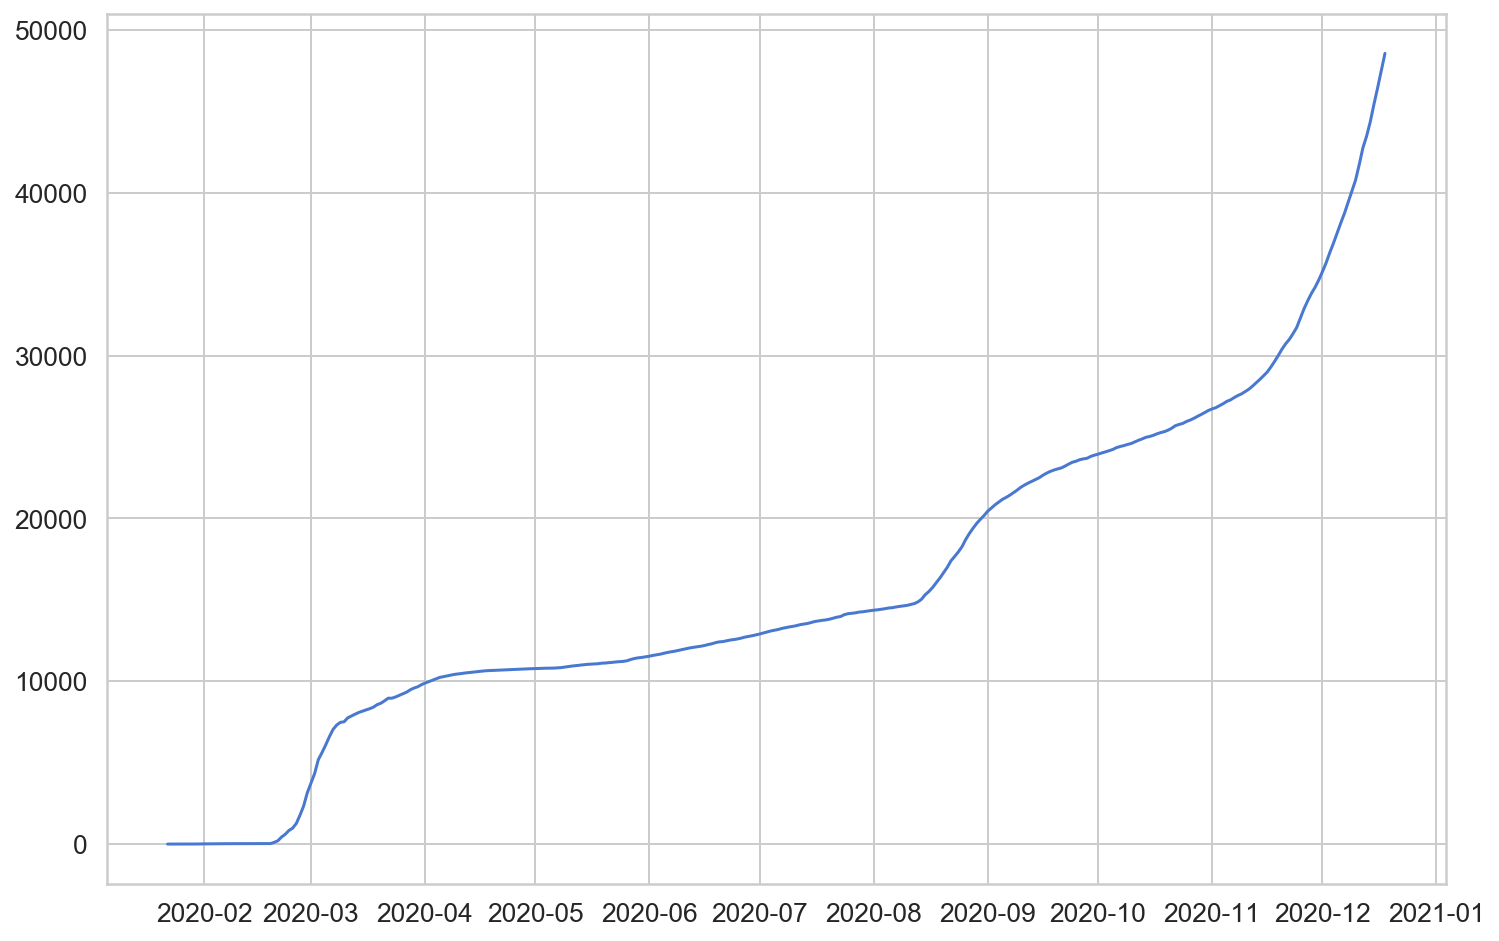

In [8]:
"""한국 확진자 수 그래프 그리기"""

## rcparams['figure.figsize']는 그래프 크기를 조정할 수 있다.
rcParams['figure.figsize'] = 12, 8
## sns.set은 격자의 색깔과 글짜 크기를 조정할 수 있다.
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.plot(korea)
plt.show()

In [9]:
"""누적데이터가 아닌 일일 단위로 확진자 수를 보자."""
## .diff()를 사용하여 이전 행과 차이를 구한다.
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int') # 누적 데이터의 첫 번째 값으로 채우기
daily_cases.head()

,157
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1


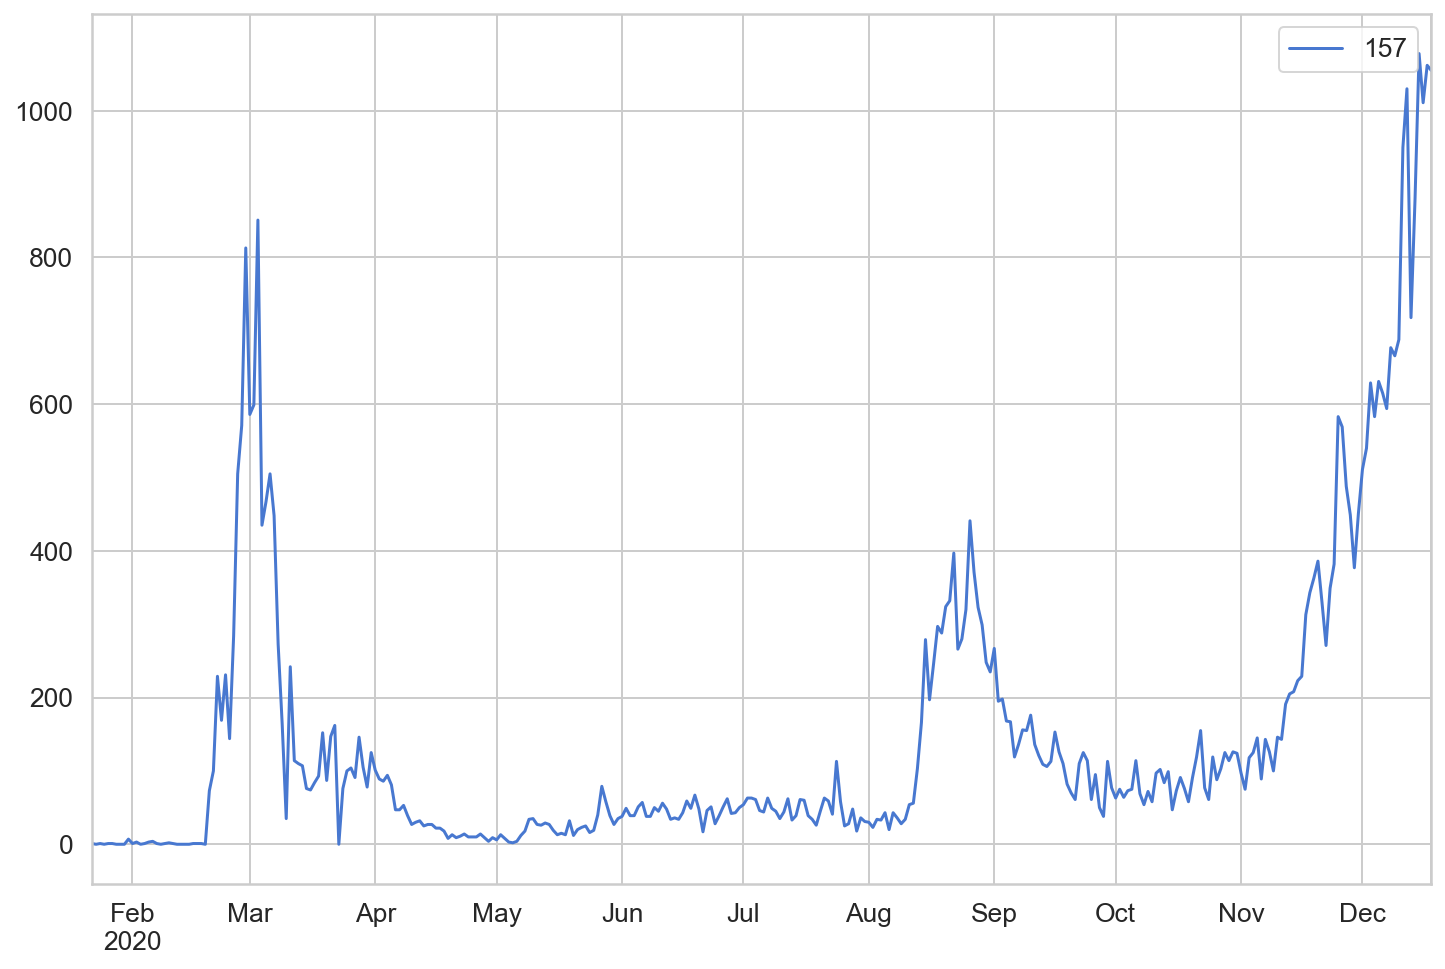

In [10]:
## 3월 초와 8월 말에 급증했다가 연말에 다시 급격하게 증가함
daily_cases.plot()

-----

## 데이터 전처리

In [11]:
"""시계열 데이터 변환 과정"""
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5

## daily_cases는 한국의 일별 코로나 확진자 수
## one step prediction을 목표로 함
X, y = create_sequences(daily_cases, seq_length)

In [12]:
"""[데이터개수, sequence_length]"""
## 총 327개의 데이터가 구성되었다.
print(X.shape, y.shape)

(327, 5, 1) (327, 1)


In [13]:
## 5일치 데이터. 일별로 feature가 하나(확진자)밖에 없기에 (5,1)의 shape을 가짐
X[0]

array([[1],
       [0],
       [1],
       [0],
       [1]])

In [14]:
"""데이터 분리"""
train_size = int(327*0.8)
print(train_size)

261


In [15]:
"""전체의 70%는 training, 15%는 validation, 15%는 testing을 진행"""
## 학습 데이터
X_train, y_train = X[:train_size], y[:train_size]
print('학습데이터: ', X_train.shape)

## 검증 데이터
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
print('검증데이터: ', X_val.shape)

## 테스트 데이터
X_test, y_test = X[train_size+33:], y[train_size+33:]
print('테스트데이터: ', X_test.shape)

학습데이터:  (261, 5, 1)
검증데이터:  (33, 5, 1)
테스트데이터:  (33, 5, 1)


----

#### Scaling
- train data의 통계량을 이용해서 valid data와 test data의 scaling 진행

In [16]:
"""MIN MAX scaling"""
MIN = X_train.min()
MAX = X_train.max()
print(MIN, MAX)

0 851


In [17]:
def MINMAXScale(array, min, max):
    return (array-min) / (max-min)

X_train = MINMAXScale(X_train, MIN, MAX)
y_train = MINMAXScale(y_train, MIN, MAX)
X_val = MINMAXScale(X_val, MIN, MAX)
y_val = MINMAXScale(y_val, MIN, MAX)
X_test = MINMAXScale(X_test, MIN, MAX)
y_test = MINMAXScale(y_test, MIN, MAX)

In [18]:
"""파이토치에 사용하기 위해 tensor 형태로 변환"""
import torch

def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

## LSTM 모델 정의
- 해당 클래스는 기본 변수, layer를 초기화 해주는 생성자, 학습 초기화를 위한 reset_hidden_state 함수, 그리고 예측을 위한 forward 함수로 구성돼 있다.

In [19]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1) # one step prediction이기에 out_features=1
    
    """파이토치는 RNN 계열의 모델에서 hidden state 정보를 계속 가지고 있다.
    seq가 돌 때마다 weight 값이 업데이트 되는데 이 때, hidden state에는 계산했던 값이 남아있는 것이다.
    따라서 매 seq마다 hidden state 값들을 초기화 해줘야 한다."""
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
        
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred
        

#### 학습
- epoch : 학습 시킬 epoch 횟수
- verbose : epoch를 verbose번째 마다 출력한다는 것
- patience : 검증용 손실값을 patience번째 epoch마다 patience 만큼의 이전 손실값과 비교해 줄어들지 않으면 학습을 종료시킬 때 사용하는 인자
- 파이토치에서 hidden_state를 보존하기 때문에 `새로운 시퀀스가 입력될 때마다 hidden_state를 초기화` 시켜야 이전 시퀀스의 hidden_state로 부터 영향을 받지 않는다.

In [43]:
for idx, seq in enumerate(X_train):
    if idx==0:
        print(seq.shape)
    else:
        break

torch.Size([5, 1])


In [44]:
X_train.shape

torch.Size([261, 5, 1])

In [20]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose=10, patience=10):
    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):
        epoch_loss = 0
        
        """batch size를 정해주지 않고 261개의 train seq를 하나씩 넣는다. """
        for idx, seq in enumerate(train_data):
            
            model.reset_hidden_state() ## seq별 hidden state reset
            
            """train loss"""
            seq = torch.unsqueeze(seq, 0) # 차원을 늘려서 파이토치 입력값 형태에 맞춰줌
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) ## 1개의 step에 대한 loss (batch size=1)
            
            """update weights"""
            optimizer.zero_grad() # 값을 0으로 만드는 게 아니라 gradient의 영향력(미분의 영향력)을 0으로 만드는 것
            loss.backward()
            optimizer.step()
            
            epoch_loss+=loss.item()
            
        train_hist.append(epoch_loss / len(train_data))
        
        """epoch 마다 평가"""
        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state() ## seq별로 hidden state 초기화
                    
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])
                    
                    val_loss += val_step_loss
                
                val_hist.append(val_loss / len(val_data)) # val hist에 추가
                
                """verbose 번째 마다 loss 출력"""
                if t%verbose ==0 :
                    print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')
                
                """patience 번째 마다 early stopping 여부 확인"""
                if (t%patience==0) & (t!=0):
                    ## loss가 커졌다면 early stop
                    if val_hist[t-patience]<val_hist[t]:
                        print('\n Early Stopping')
                        break
                        
        elif t % verbose==0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')
                
    return model, train_hist, val_hist

In [21]:
model = LSTM(
    n_features = 1,
    n_hidden = 4,
    seq_len = seq_length,
    n_layers=1
)

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=200,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.0846735673931595 val loss: 0.047220390290021896
Epoch 10 train loss: 0.03268902708323123 val loss: 0.03414301201701164
Epoch 20 train loss: 0.0325592671845722 val loss: 0.03243740275502205
Epoch 30 train loss: 0.03268276141524686 val loss: 0.03306415677070618
Epoch 40 train loss: 0.03259286372672581 val loss: 0.03251414746046066
Epoch 50 train loss: 0.03231643671366133 val loss: 0.03300009295344353
Epoch 60 train loss: 0.03259848010141074 val loss: 0.03266563639044762
Epoch 70 train loss: 0.032208833890749404 val loss: 0.03289765492081642
Epoch 80 train loss: 0.03264666241914805 val loss: 0.03258885070681572
Epoch 90 train loss: 0.032349444334341705 val loss: 0.03221791610121727
Epoch 100 train loss: 0.03260009843049664 val loss: 0.03318183496594429

 Early Stopping


---

### 손실값 시각화

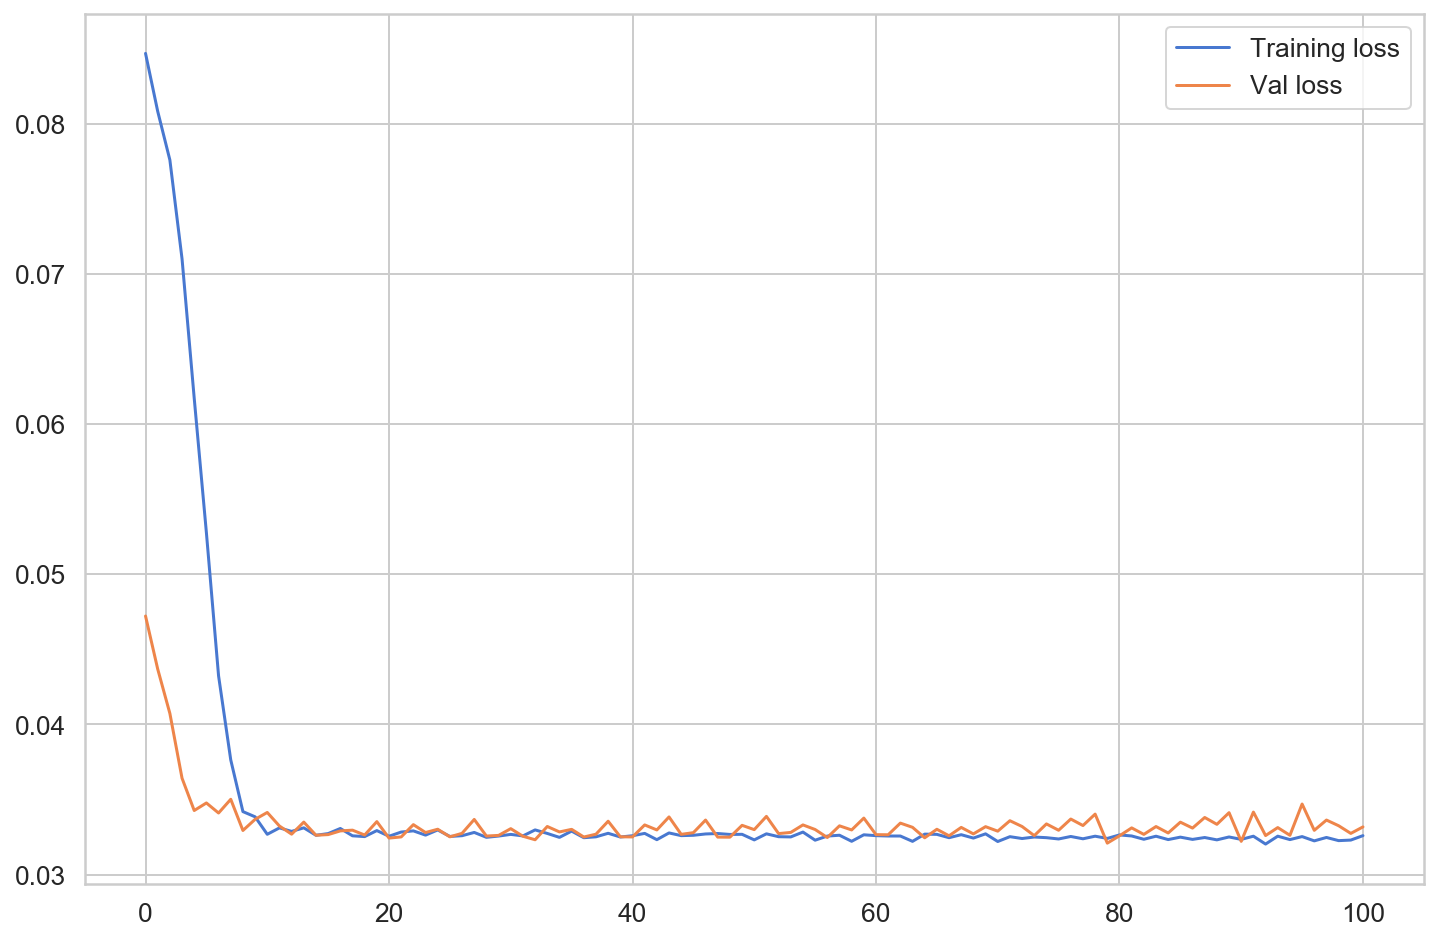

In [22]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label='Val loss')
plt.legend()

-----

### One-Step 예측
- 예측할 때도 새로운 시퀀스가 입력될 때 마다 hidden_state는 초기화 해줘야 이전 hidden_state가 반영되지 않는다.
- torch.unsqueeze 함수를 사용하여 입력 데이터의 차원을 늘려 모델이 예상하는 3차원 형태로 만들어준다.
- 예측된 데이터 내에 존재하는 scalar 값만 추출하여 preds 리스트에 추가한다.

In [25]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

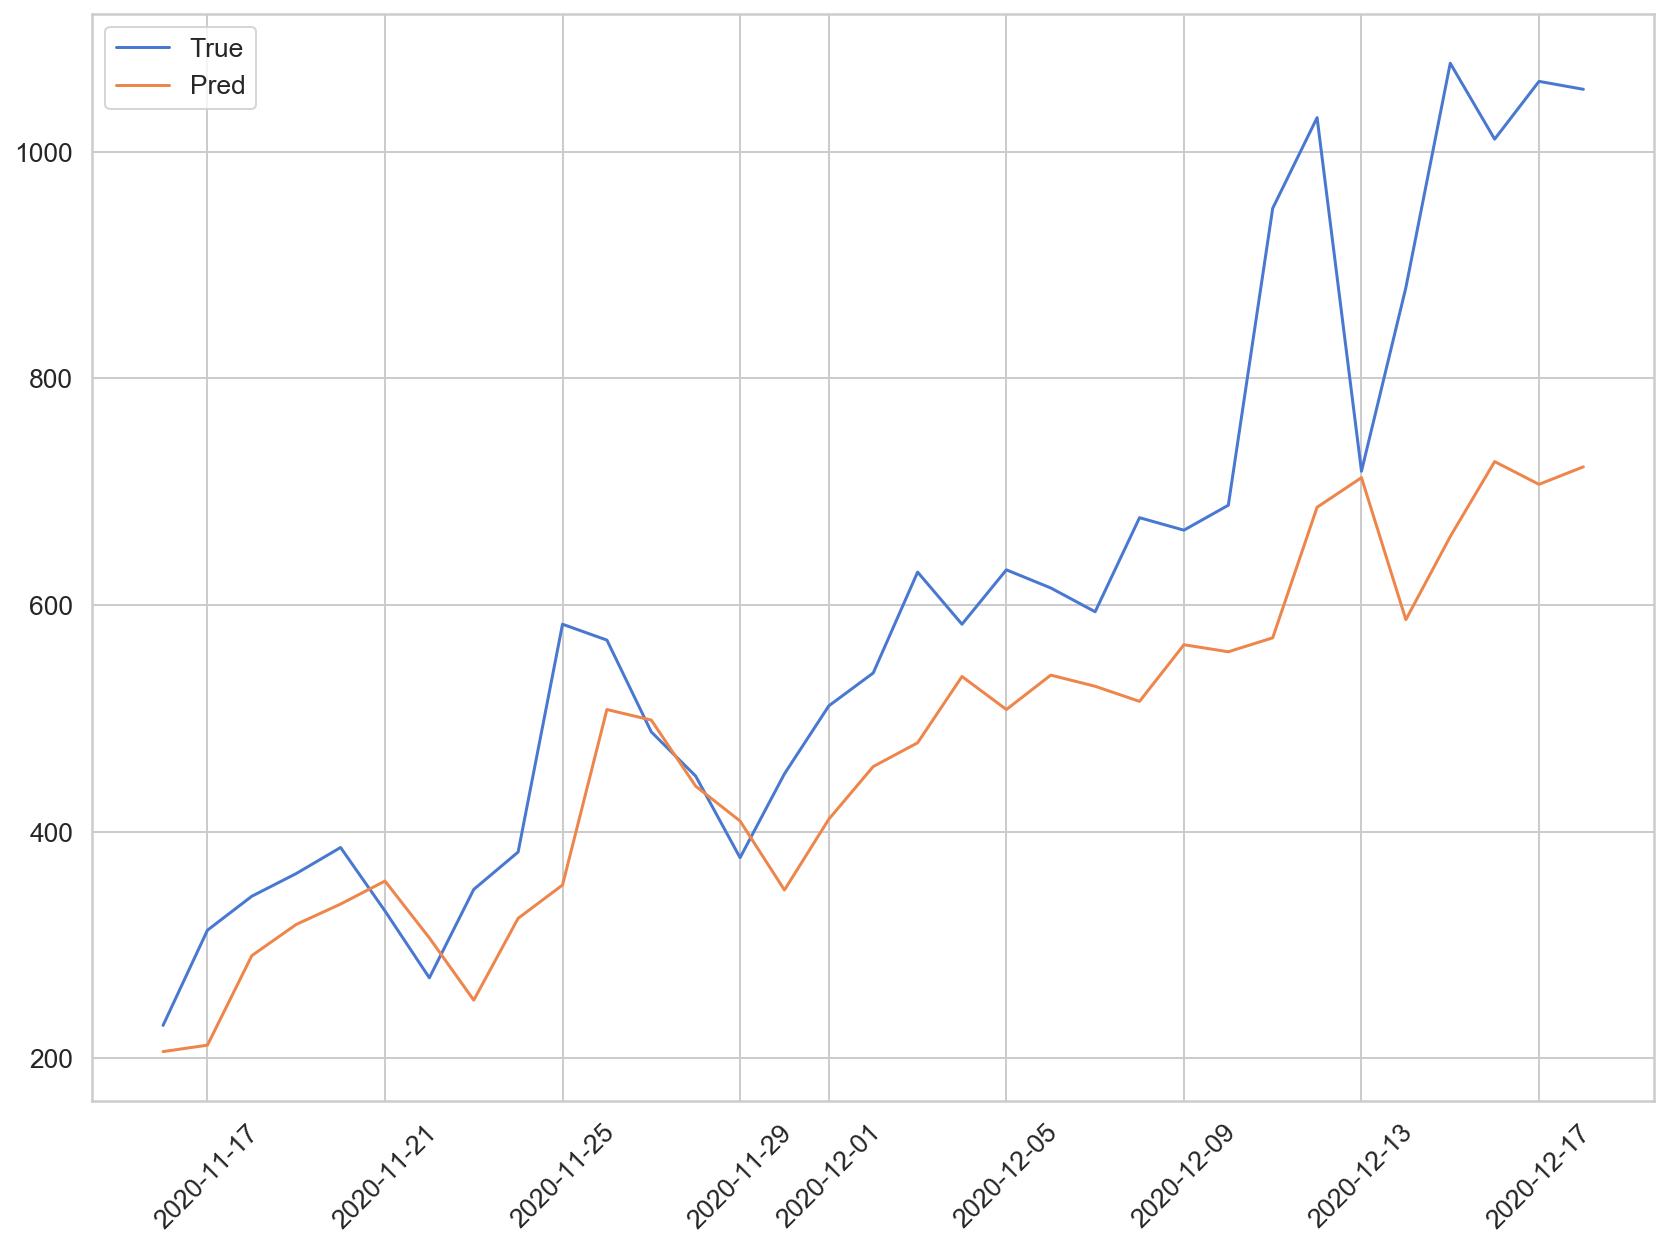

In [30]:
## 확진자가 급격하게 증가하는 구간에 대해서는 예측을 제대로 하지 못함
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [31]:
"""예측값의 평균 오차 구하기"""
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [33]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

246.81040849622178

### Multi-Step 예측
- One-Step 예측 모델을 반복적으로 활용해 Multi-Step 예측을 진행한다. test 데이터의 첫 번째 sample을 활용해 나온 예측값을 입력 시퀀스에 포함시켜 예측하고, 이 과정을 반복한다.

In [37]:
"""이러한 방법은 예측 기간이 길어질수록 오차가 누적되어 모델의 성능을 보장하기 어렵다."""
with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 데이터셋 (3차원으로 인덱싱)
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 예측한 값을 시퀀스에 추가
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기=맨 뒤의 값을 빼기
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        

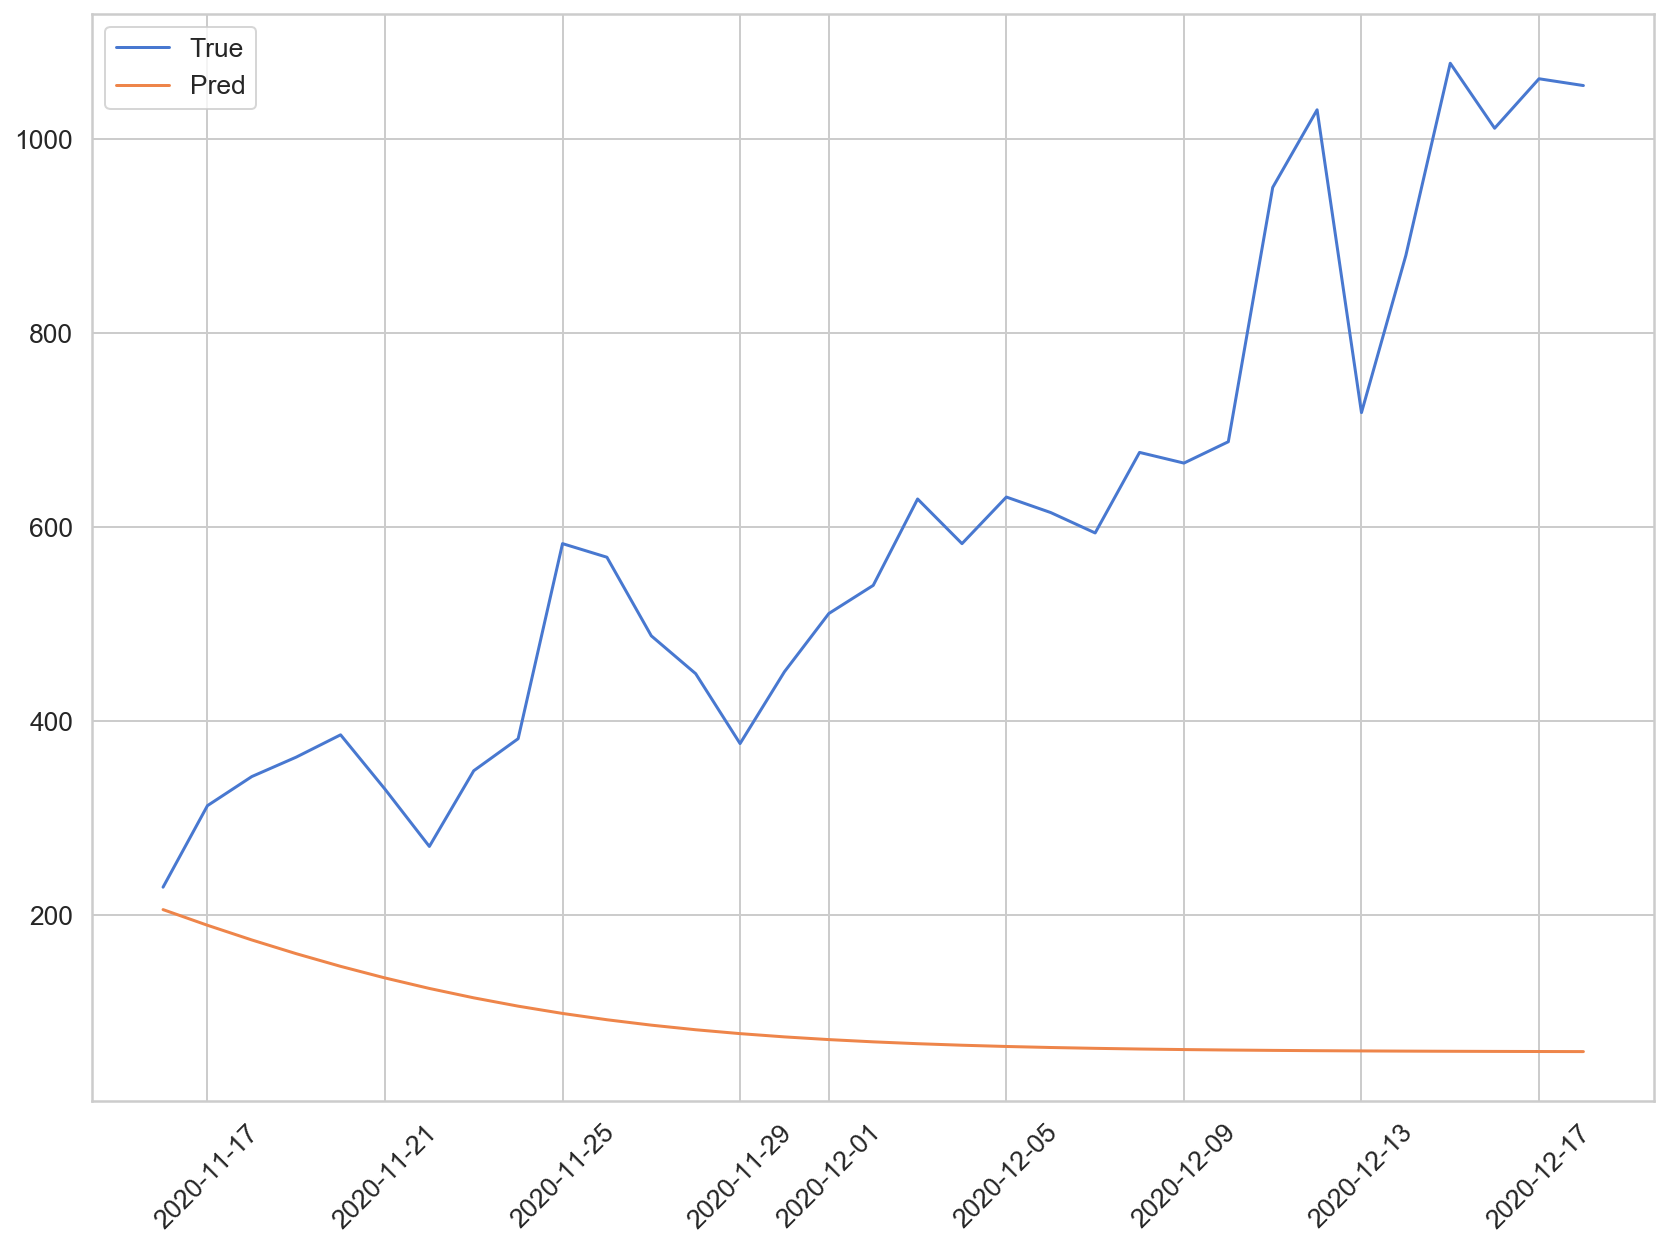

In [38]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [40]:
X_train.shape

torch.Size([261, 5, 1])